In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()
y = train_data["Survived"]
X = train_data.drop("Survived", axis=1)
X.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
#        'Ticket', 'Fare', 'Cabin', 'Embarked'],
#       dtype='object')

# Data exploration
survived_women = train_data.loc[train_data.Sex == "female"]['Survived']
mean_survived_women = survived_women.mean()
print("% of women who survived:", mean_survived_women)

survived_men = train_data.loc[train_data.Sex == "male"]['Survived']
mean_survived_men = survived_men.mean()
print("% of women who survived:", mean_survived_men)


survival_rate = train_data["Survived"].mean()
print("% of true instance:", survival_rate)
# 38 percent, mildly imbalance true instance

# Quick overview
# 891 rows
print(X.shape)
print(X.info())


% of women who survived: 0.7420382165605095
% of women who survived: 0.18890814558058924
% of true instance: 0.3838383838383838
(891, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB
None


In [4]:
from sklearn.preprocessing import FunctionTransformer

features = ["Pclass", "Sex", "FamilySize", "Age", "Fare", "Title",  "isAlone", "Title_Sex"]

def pluck_important_feature(df):
    return df[features]

# feature engineering
def add_engineered_feature(df):
    df = df.copy()
    
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.')
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

    df["isAlone"] = (df['FamilySize'] == 1).astype(int)

    df['Title_Sex'] = df['Title'] + '_' + df['Sex']
    
    return df

# fill na values
def fill_na_values(df):
    df = df.copy()
    
    df["Age"] = df["Age"].fillna(df["Age"].median())
    df["Fare"] = df["Fare"].fillna(df["Fare"].median())
    
    return df

add_engineered_feature_transformer = FunctionTransformer(add_engineered_feature)
fill_na_values_transformer = FunctionTransformer(fill_na_values)
pluck_important_feature_transformer = FunctionTransformer(pluck_important_feature)

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier


categorical = ["Pclass", "Sex", "Title", "Title_Sex"]

preprocessor = ColumnTransformer(
    transformers = [
        ("cat", OneHotEncoder(), categorical)
    ],
    remainder="passthrough"
)

clf = Pipeline(steps=[
    ("add_engineered_feature", add_engineered_feature_transformer),
    ("pluck_important_feature", pluck_important_feature_transformer),
    ("fill_na_values", fill_na_values_transformer),
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

In [6]:
from sklearn.model_selection import GridSearchCV

# setup for hyper parameter tuning
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [4, 5, 6, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    # "model__class_weight": [None, 'balanced', {0: 0.6, 1: 1.4},],
    "model__class_weight": [{0: 0.6, 1: 1.4}]
}

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,               # number of folds
    scoring=['accuracy', 'roc_auc', 'recall', 'f1'],
    refit='f1',
    n_jobs=-1           # use all CPU cores
)



In [7]:
from sklearn.metrics import accuracy_score

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

grid_search.fit(X_train, y_train)

# Access the best pipeline after GridSearchCV
best_estimator = grid_search.best_estimator_

In [8]:
# evaluate accuracy
val_preds = best_estimator.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, val_preds))

# evaluate feature importance
# Get the model from inside the pipeline
rf_model = best_estimator.named_steps["model"]

# Feature importances
feature_importance = rf_model.feature_importances_

for feature_name, imp in zip(features, feature_importance):
    print ("feature:", feature_name, ", importance:", imp)

Validation Accuracy: 0.8156424581005587
feature: Pclass , importance: 0.04794619506641274
feature: Sex , importance: 0.023470893118689853
feature: FamilySize , importance: 0.049780792660743825
feature: Age , importance: 0.11720333610086334
feature: Fare , importance: 0.0884709822163808
feature: Title , importance: 0.008849714448550216
feature: isAlone , importance: 0.024221830809515347
feature: Title_Sex , importance: 0.14713013831707714


                 precision    recall  f1-score   support

Did Not Survive       0.90      0.79      0.84       110
       Survived       0.72      0.86      0.78        69

       accuracy                           0.82       179
      macro avg       0.81      0.82      0.81       179
   weighted avg       0.83      0.82      0.82       179



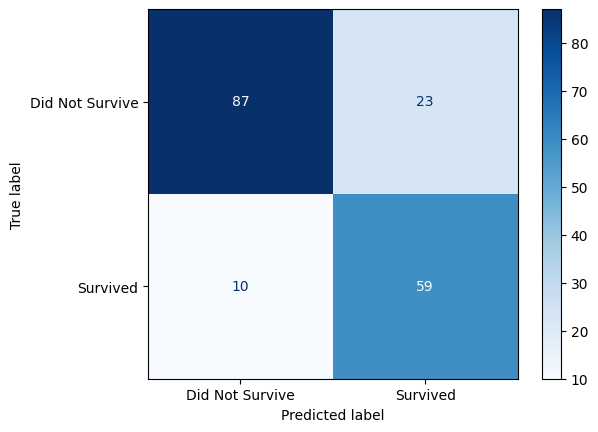

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_val, val_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Did Not Survive", "Survived"])
disp.plot(cmap="Blues")

print(classification_report(y_val, val_preds, target_names=["Did Not Survive", "Survived"]))

In [10]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_estimator, X, y, cv=5, scoring="f1")
print("CV F1 scores:", cv_scores)
print("Mean F1:", cv_scores.mean(), "± Std:", cv_scores.std())

# cv_scores = cross_val_score(best_estimator, X, y, cv=5, scoring="roc_auc")
# print("CV roc_auc scores:", cv_scores)
# print("Mean roc_auc:", cv_scores.mean(), "± Std:", cv_scores.std())

CV F1 scores: [0.76923077 0.74324324 0.81690141 0.73170732 0.82993197]
Mean F1: 0.7782029421574006 ± Std: 0.039084491785663596


In [11]:
# submission
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
passenger_ids = test_data['PassengerId'].copy()
predictions = best_estimator.predict(test_data)

output = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': predictions
})

output.to_csv('submission.csv', index=False)

print(f"Submission shape: {output.shape}")
print(output.head())
print(f"Predictions: {output['Survived'].sum()} survived, {len(output) - output['Survived'].sum()} died")

Submission shape: (418, 2)
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
Predictions: 187 survived, 231 died
